## Utilizando T -SNE mnist

In [1]:
#importando bibliotecas
import pandas as pd

#Lendo base de dados

df_tse = pd.read_excel(r'C:\Users\vidal\Downloads\TCC\ClassificacaoCondutores\df_final.xlsx')

df_tse = df_tse[['velocidade', 'rpm', 'temperatura', 'pressao',
       'engineload', 'throttlePosition', 'limite_velocidade', 'dataColetaDados']]


In [2]:
#Algums tratamento para geração de coluna de aceleração
df_tse = df_tse.set_index('dataColetaDados')

df_tse['diff_tempo'] = df_tse.index.to_series().diff().dt.total_seconds()
df_tse['velocidade_convertida'] = df_tse['velocidade'] / 3.6
df_tse['diff_velocidade'] = df_tse['velocidade_convertida'].diff()  
df_tse['aceleracao_derivada'] = df_tse['diff_velocidade'] / df_tse['diff_tempo']
df_tse['aceleracao_derivada'] = df_tse['aceleracao_derivada'].fillna(0)

df_tse = df_tse[df_tse['limite_velocidade'] > 0]

df_tse = df_tse.reset_index()
df_tse = df_tse[['velocidade', 'rpm', 'temperatura', 'pressao',
       'engineload', 'throttlePosition', 'limite_velocidade', 'aceleracao_derivada']]


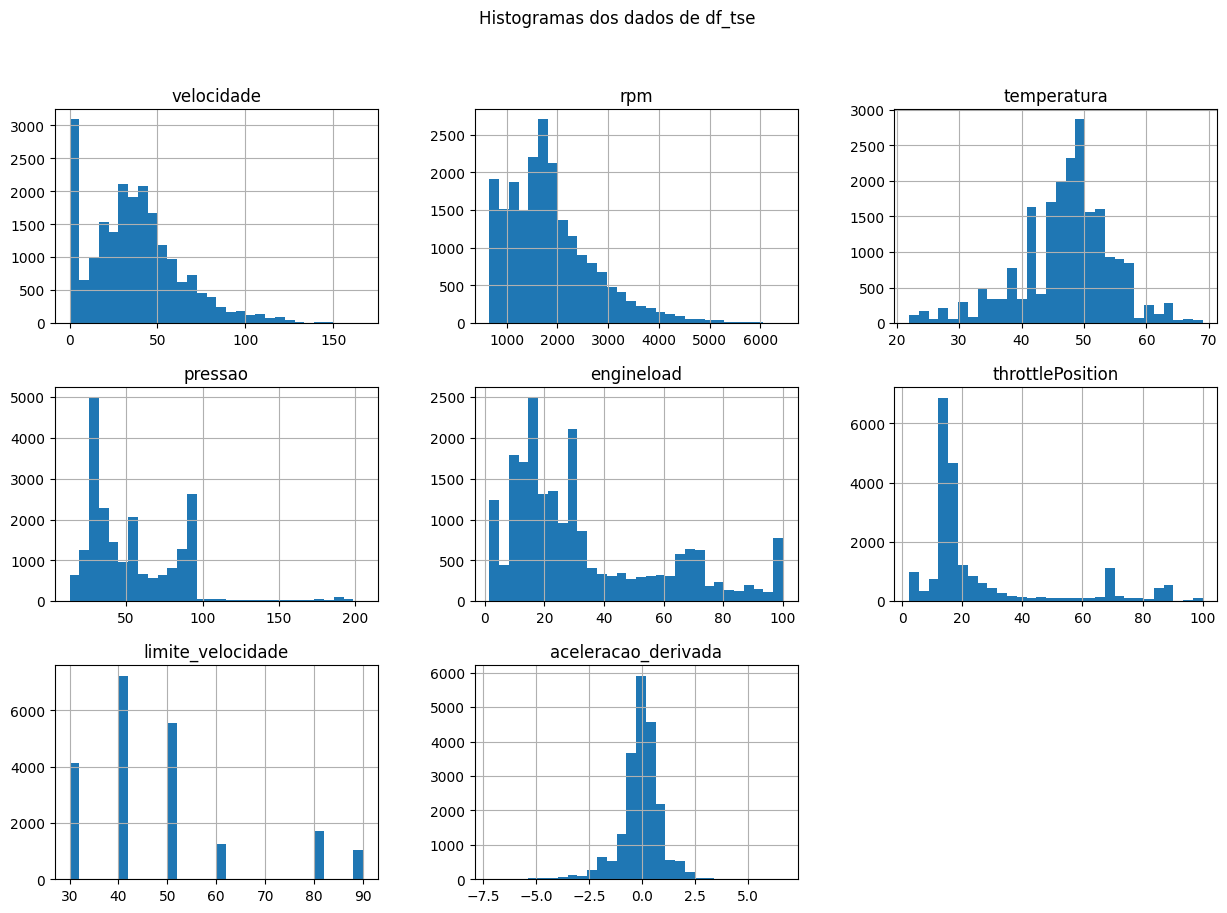

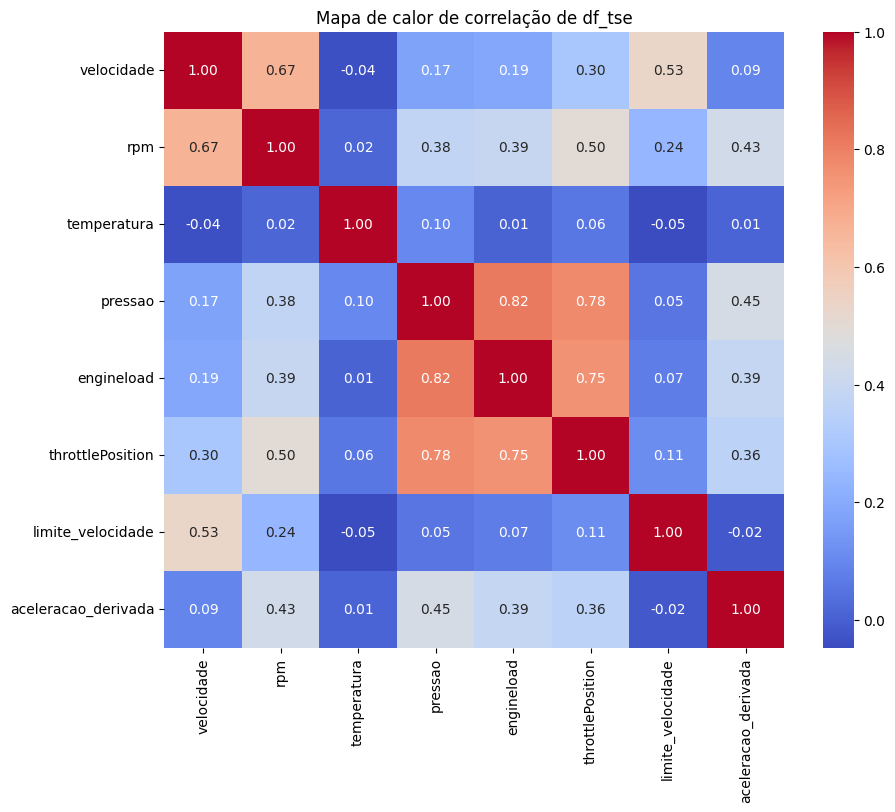

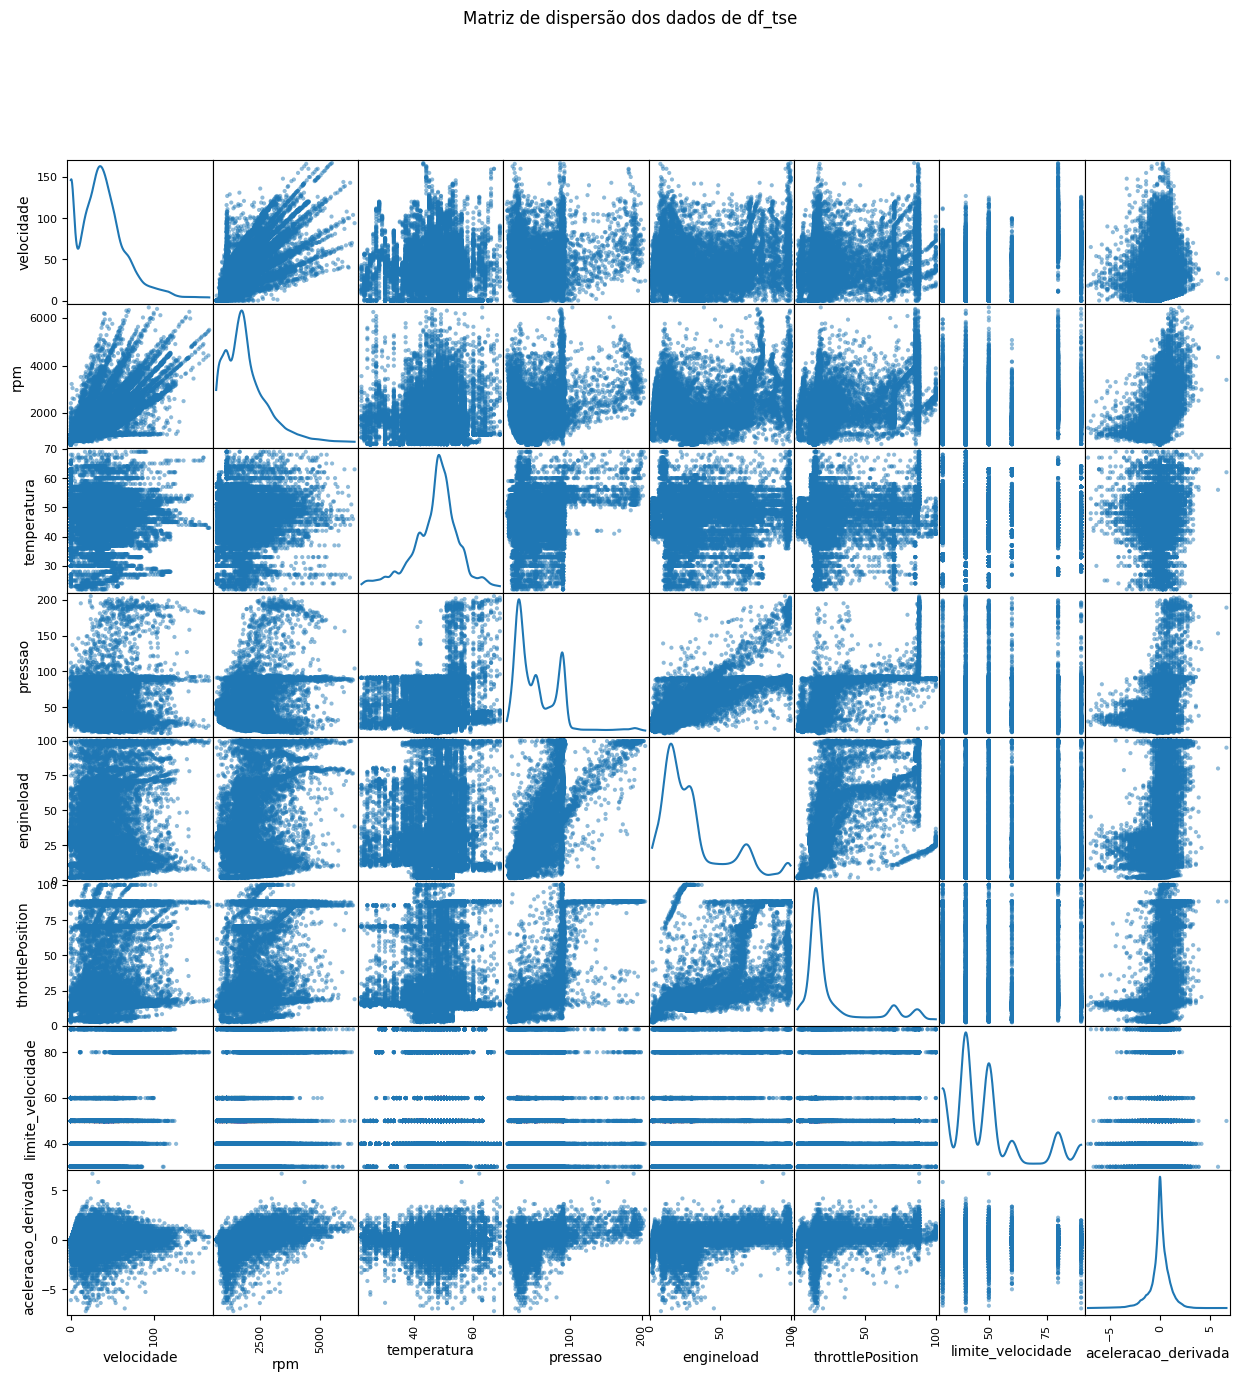

In [3]:
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Histogramas dos dados do df_tse
df_tse.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas dos dados de df_tse")
plt.show()

# Mapa de calor de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_tse.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de calor de correlação de df_tse")
plt.show()

# Matriz de dispersão
scatter_matrix(df_tse, figsize=(15, 15), diagonal='kde')
plt.suptitle("Matriz de dispersão dos dados de df_tse")
plt.show()

c:\Users\vidal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


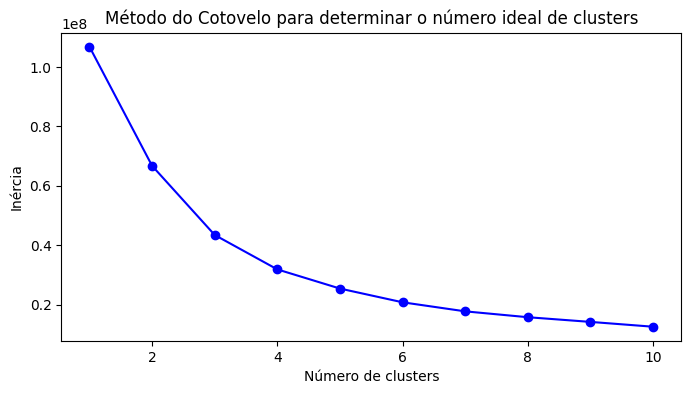

In [4]:
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Normalizar os dados antes do t-SNE (recomendado)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_tse)

# Aplicar t-SNE para reduzir a dimensionalidade para 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

# Transformar o resultado em um DataFrame
tsne_df = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])

distortions = []
K = range(1, 11)  # testando de 1 a 10 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_tsne)
    distortions.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para determinar o número ideal de clusters')
plt.show()


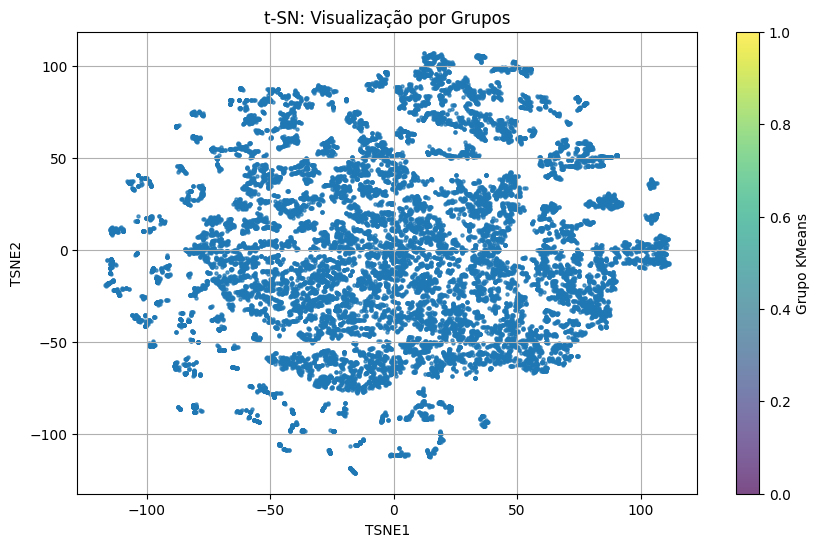

In [7]:
# Aplicar KMeans para encontrar os grupos
kmeans = KMeans(n_clusters=10, random_state=42)
tsne_df['grupo'] = kmeans.fit_predict(tsne_df[['TSNE1', 'TSNE2']])

df_completo = df_tse.copy()  # cópia dos dados originais
df_completo['TSNE1'] = tsne_df['TSNE1']
df_completo['TSNE2'] = tsne_df['TSNE2']
df_completo['grupo'] = tsne_df['grupo']

# Plotar com cores por grupo
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], 
                        s=5, alpha=0.7)
plt.colorbar(scatter, label='Grupo KMeans')
plt.title('t-SN: Visualização por Grupos')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.show()


df_completo['ultrapassou_vel'] = df_completo['velocidade'] > df_completo['limite_velocidade']
df_completo['ultrapassou_vel_20'] = df_completo['velocidade'] > (df_completo['limite_velocidade'] * 1.2)
df_completo['ultrapassou_vel_50'] = df_completo['velocidade'] > (df_completo['limite_velocidade'] * 1.5)
df_completo['aceleracao_brupta'] = df_completo['aceleracao_derivada'] > 2.0
df_completo['desaceleracao_brupta'] = df_completo['aceleracao_derivada'] < -3.5

6120


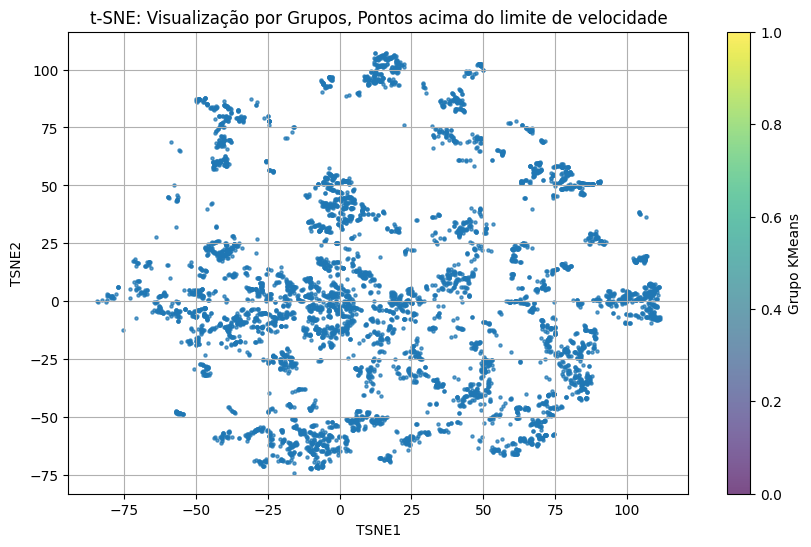

In [11]:
#Inferição dos grupos encontrados pelo KMeans. Sera que existe um grupo agressivo?
df_analise = df_completo.copy()
df_analise = df_analise[df_analise['ultrapassou_vel'] == True]

print(len(df_analise))


# Plotar com cores por grupo
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_analise['TSNE1'], df_analise['TSNE2'], 
                       s=5, alpha=0.7)
plt.colorbar(scatter, label='Grupo KMeans')
plt.title('t-SNE: Visualização por Grupos, Pontos acima do limite de velocidade')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.show()

c:\Users\vidal\Downloads\TCC\PYTHON_TCC\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


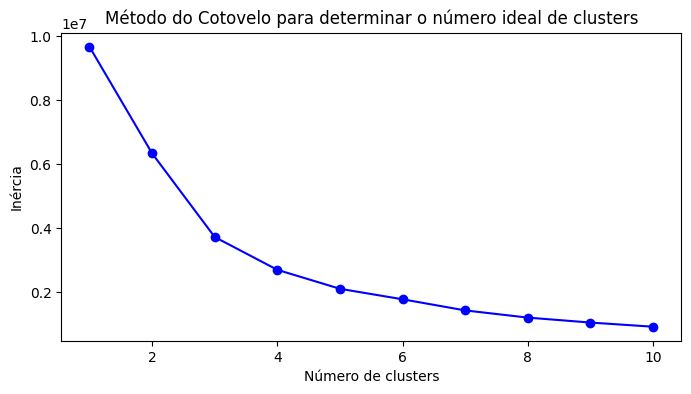

In [16]:
#Utlizando PCA para reduzir a dimensionalidade antes do t-SNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Normalizar os dados antes do PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_tse)

# Aplicar PCA para reduzir a dimensionalidade inicial
pca = PCA(n_components=4)  # Reduzindo para 50 componentes antes do t-SNE
data_pca = pca.fit_transform(data_scaled)

# Aplicar t-SNE para reduzir a dimensionalidade para 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
data_tsne = tsne.fit_transform(data_pca)

# Transformar o resultado em um DataFrame
tsne_df = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])

# Determinar o número ideal de clusters pelo método do cotovelo
distortions = []
K = range(1, 11)  # testando de 1 a 10 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_tsne)
    distortions.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para determinar o número ideal de clusters')
plt.show()




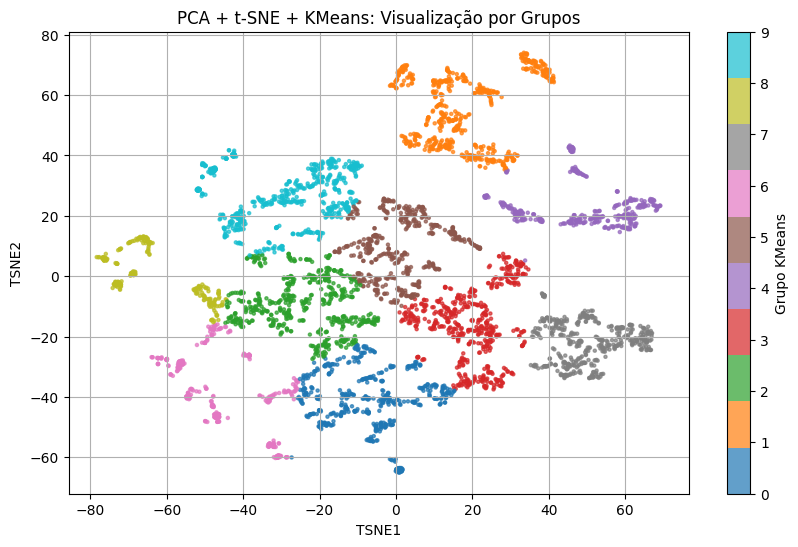

In [17]:
# Aplicar KMeans para encontrar os grupos
kmeans = KMeans(n_clusters=10, random_state=42)
tsne_df['grupo'] = kmeans.fit_predict(tsne_df[['TSNE1', 'TSNE2']])

# Adicionar os componentes transformados ao DataFrame original
df_completo = df_tse.copy()
df_completo['TSNE1'] = tsne_df['TSNE1']
df_completo['TSNE2'] = tsne_df['TSNE2']
df_completo['grupo'] = tsne_df['grupo']

# Plotar os resultados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], 
                      c=tsne_df['grupo'], cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, label='Grupo KMeans')
plt.title('PCA + t-SNE + KMeans: Visualização por Grupos')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.show()

# Criar novas colunas baseadas nos critérios de velocidade e aceleração
df_completo['ultrapassou_vel'] = df_completo['velocidade'] > df_completo['limite_velocidade']
df_completo['ultrapassou_vel_20'] = df_completo['velocidade'] > (df_completo['limite_velocidade'] * 1.2)
df_completo['ultrapassou_vel_50'] = df_completo['velocidade'] > (df_completo['limite_velocidade'] * 1.5)
df_completo['aceleracao_brupta'] = df_completo['aceleracao_derivada'] > 2.0
df_completo['desaceleracao_brupta'] = df_completo['aceleracao_derivada'] < -3.5

1228


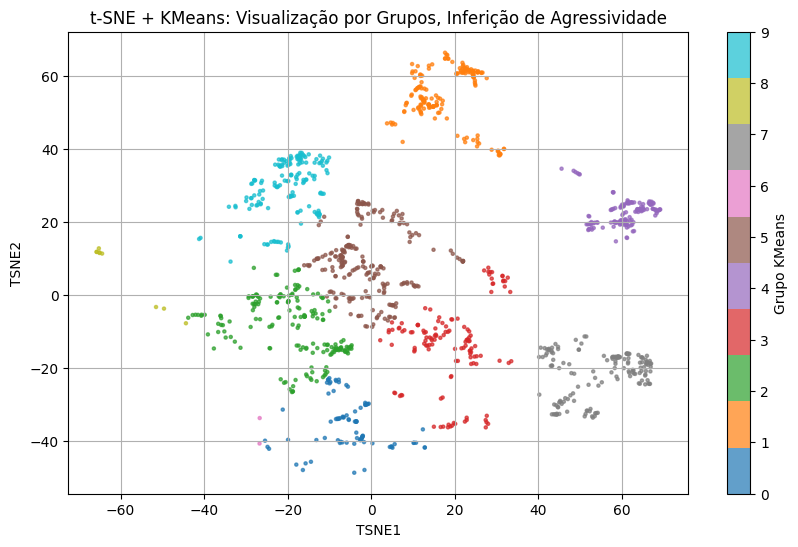

In [18]:
#Inferição dos grupos encontrados pelo KMeans. Sera que existe um grupo agressivo?
df_analise = df_completo.copy()
df_analise = df_analise[df_analise['ultrapassou_vel'] == True]

print(len(df_analise))


# Plotar com cores por grupo
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_analise['TSNE1'], df_analise['TSNE2'], 
                      c=df_analise['grupo'], cmap='tab10', s=5, alpha=0.7)
plt.colorbar(scatter, label='Grupo KMeans')
plt.title('t-SNE + KMeans: Visualização por Grupos, Inferição de Agressividade')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.show()